In [1]:
import os
import glob

import numpy as np
import scipy.stats
import pandas as pd
import pytz

import act
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

* use script `analysis/sail/lidar_wind_profile_synoptic_wind_coherence.py` to download synoptic wind data
* use `cumulative_sublimation.ipynb` to create daily dataset
* use `analysis/sos/create_turbulence_dataset.ipynb` to create SoS tidy dataset and the (disdrometer) precip data

In [2]:
# Inputs
start_date = '20221130'
end_date = '20230509'
met_gothic = 'gucmetM1.b1'
tsi_sail_code = 'guctsiskycoverM1.b1'
data_dir = '/data2/elilouis/sublimationofsnow'
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

daily_tidy_dataset_fn = 'tidy_df_daily_20221130_20230509_noplanar_fit.parquet'

### Open Data 

#### SoS

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])


tidy_df_daily = pd.read_parquet(daily_tidy_dataset_fn)

#### Precip data

In [4]:
precip_df = pd.read_csv("../sos/disdro_daily_max_precip_date_df.csv")
precip_df['time'] = pd.to_datetime(precip_df['time'])

#### SAIL TSI

In [5]:
sail_tsi_dir = os.path.join(data_dir, tsi_sail_code)

print("Downloading")
# act.discovery.download_data(
#     username,    token,    tsi_sail_code,    startdate=start_date,   enddate=end_date,
#     output = sail_tsi_dir
# )
print("Loading")
tsi_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(sail_tsi_dir, '*.cdf'))
)

Downloading
Loading


#### SAIL Sonde

In [6]:
synoptic_winds_df = pd.read_parquet('../sail/synoptic_winds_500_local.parquet')
synoptic_winds_df = synoptic_winds_df.groupby("time").mean().reset_index()

#### SAIL Met

In [7]:
met_gothic_path = os.path.join(data_dir, met_gothic)

In [8]:
met_gothic_path = os.path.join(data_dir, met_gothic)

# act.discovery.download_data(
#     username, token, met_gothic, start_date, end_date,
#     output = met_gothic_path
# )

In [9]:
met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(met_gothic_path, '*.cdf')))

In [10]:
met_gothic_ds = utils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
met_gothic_ds = met_gothic_ds.sel(time=slice(start_date,end_date))

## Prep daily datasets and combine

In [11]:
tidy_df_daily_variables = pd.concat([
    tidy_df_daily.query("tower == 'd'").query("height == 3").query("variable == 'Cumulative sublimation (mm)'"),
    tidy_df_daily[tidy_df_daily.variable == 'Rsw_in_9m_d'],
    tidy_df_daily[tidy_df_daily.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].groupby("time").max().reset_index()
])

tidy_df_daily_variables = tidy_df_daily_variables[['time', 'measurement', 'value']].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()

In [12]:
tsi_ds_daily = tsi_ds.resample(time='1440Min').mean()
tsi_daily_df = tsi_ds_daily[['sunny', 'percent_opaque']].to_dataframe().reset_index()

In [13]:
synoptic_winds_daily_df = synoptic_winds_df.set_index('time').groupby(pd.Grouper(freq='1440Min')).mean().reset_index()

In [14]:
combo_df = synoptic_winds_daily_df.merge(
    tsi_daily_df, on='time', how='inner'
).merge(
    tidy_df_daily_variables, on='time', how='inner'
)

# Plot

## Hourly data

Wind speed and blowing snow flux

(0.0, 1.0)

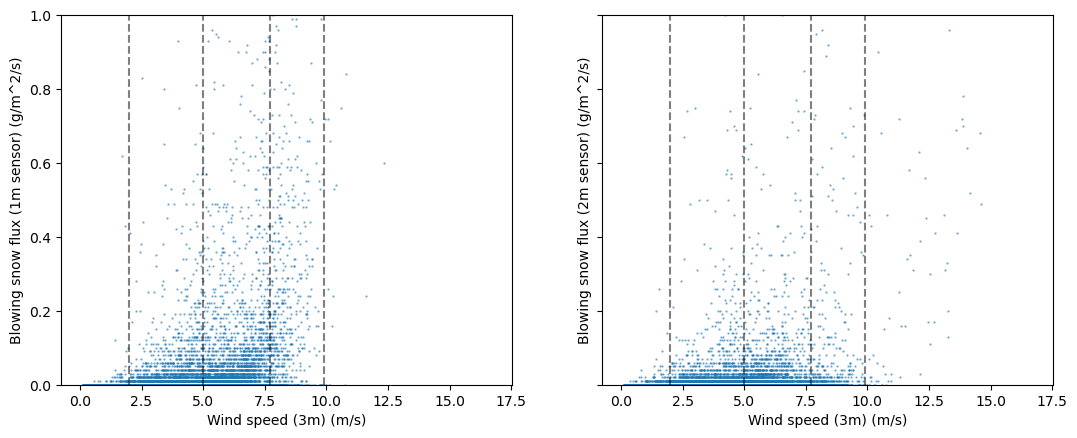

In [16]:

fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")

plt.ylim(0,1)


(0.0, 1.0)

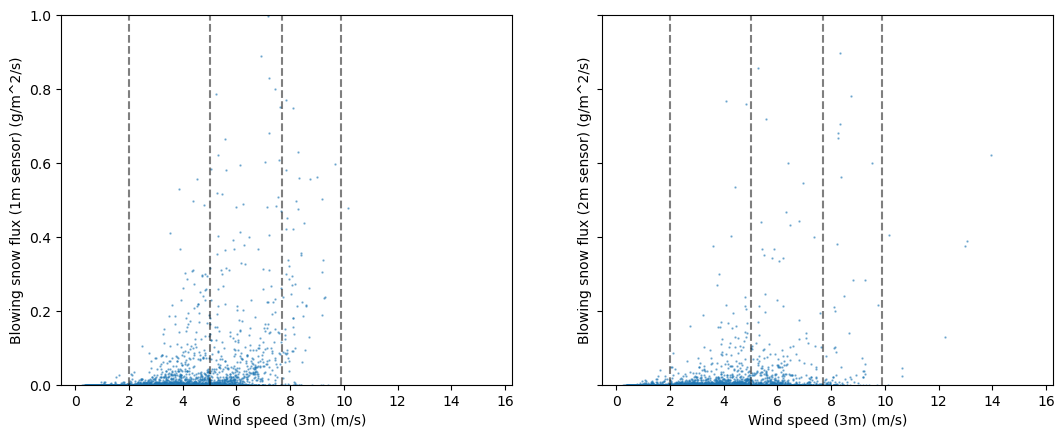

In [15]:

fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_30Min.query("variable == 'spd_3m_c'").value,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_30Min.query("variable == 'spd_3m_c'").value,
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")

plt.ylim(0,1)


/tmp/ipykernel_10863/2242883318.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


(0.006346872706983886, 1)

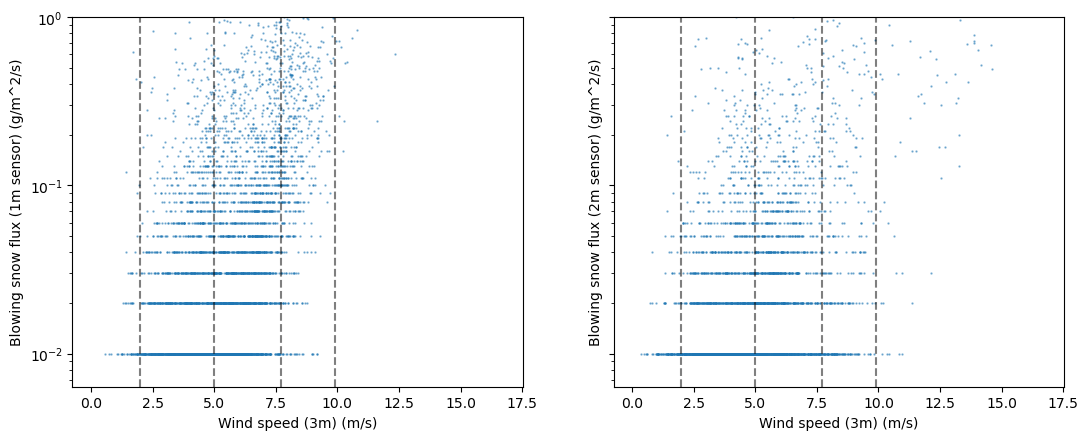

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.ylim(0,1)


/tmp/ipykernel_10863/3574906579.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


(0.0009957157485810172, 1)

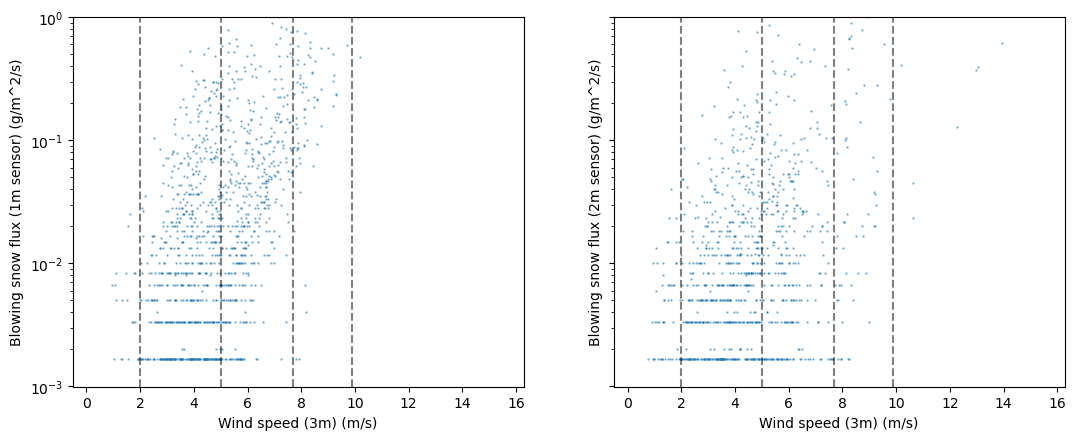

In [19]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_30Min.query("variable == 'spd_3m_c'").value,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_30Min.query("variable == 'spd_3m_c'").value,
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.ylim(0,1)


Shear velocity and blowing snow flux

(0.0, 1.0)

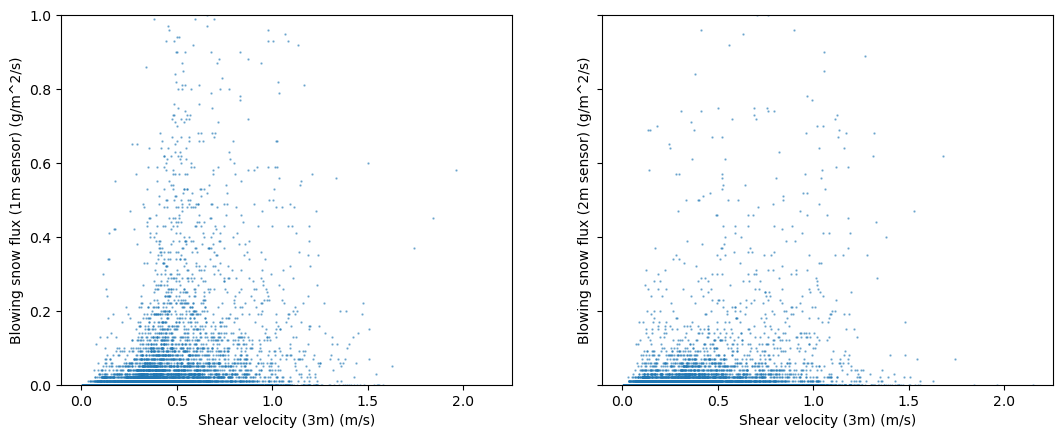

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'u*_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'u*_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Shear velocity (3m) (m/s)")
axes[1].set_xlabel("Shear velocity (3m) (m/s)")

plt.ylim(0,1)

(0.0, 1.0)

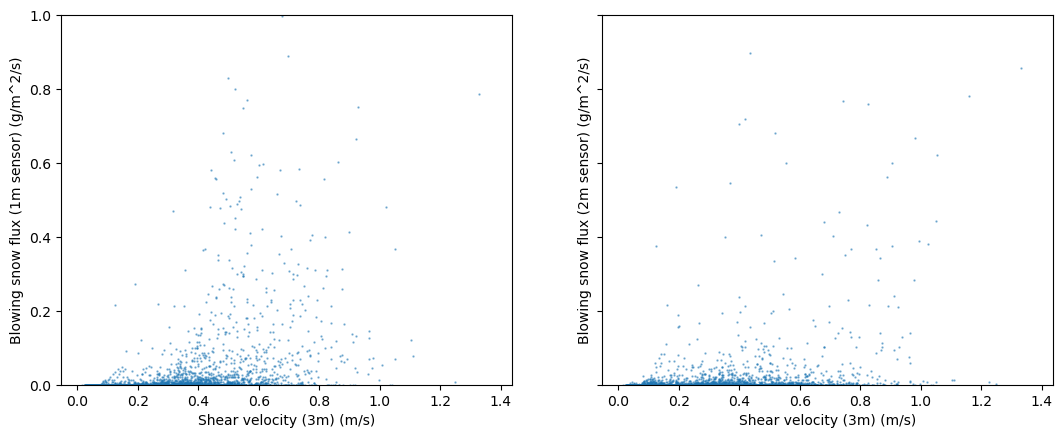

In [16]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)

axes[0].scatter(
    tidy_df_30Min.query("variable == 'u*_3m_c'").value,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_30Min.query("variable == 'u*_3m_c'").value,
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Shear velocity (3m) (m/s)")
axes[1].set_xlabel("Shear velocity (3m) (m/s)")

plt.ylim(0,1)

These weren't particularly useful, let's stick with the wind speed threshold idea

Split dataset into blowing snow and calm 

A 2 m/s threshold for wind speed looks like a reasonable. Lets look at distribution of snow flux values for wind speeds less than and greater than 2 m/s.

In [21]:
high_wind_speed_df = tidy_df_5Min[
    tidy_df_5Min.time.isin(
        tidy_df_5Min.query("variable == 'spd_3m_c'").query("value > 2").time.unique()
    )
]
low_wind_speed_df = tidy_df_5Min[
    ~ tidy_df_5Min.time.isin(
        tidy_df_5Min.query("variable == 'spd_3m_c'").query("value > 2").time.unique()
    )
]

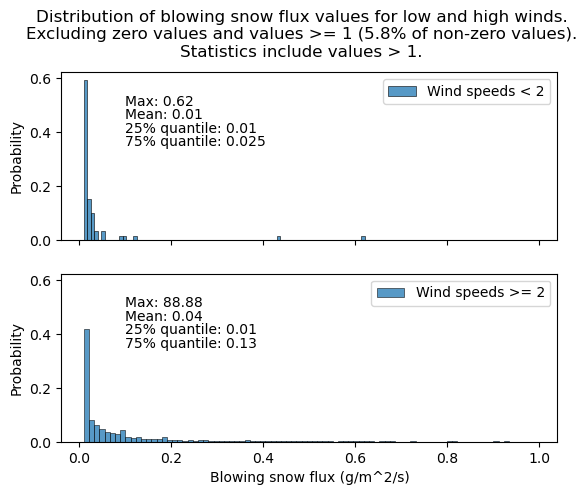

In [57]:
import seaborn as sns
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
sns.histplot(low_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").query("value < 1").value, label = 'Wind speeds < 2', stat='probability', ax = axes[0])
[q25, q50, q75] = np.quantile(
    low_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").value.dropna(),
    [0.25, 0.5, 0.75]
)
axes[0].annotate("Max: " + str(round(low_wind_speed_df.query("variable == 'SF_avg_1m_ue'").value.max(), 4)), xy=(0.1, 0.5))
axes[0].annotate("Mean: " + str(round(q50, 4)), xy=(0.1, 0.45))
axes[0].annotate("25% quantile: " + str(round(q25, 4)), xy=(0.1, 0.4))
axes[0].annotate("75% quantile: " + str(round(q75, 4)), xy=(0.1, 0.35))

sns.histplot(high_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").query("value < 1").value, label = 'Wind speeds >= 2', stat='probability', ax = axes[1])
[q25, q50, q75] = np.quantile(
    high_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").value.dropna(),
    [0.25, 0.5, 0.75]
)
axes[1].annotate("Max: " + str(round(high_wind_speed_df.query("variable == 'SF_avg_1m_ue'").value.max(), 4)), xy=(0.1, 0.5))
axes[1].annotate("Mean: " + str(round(q50, 4)), xy=(0.1, 0.45))
axes[1].annotate("25% quantile: " + str(round(q25, 4)), xy=(0.1, 0.4))
axes[1].annotate("75% quantile: " + str(round(q75, 4)), xy=(0.1, 0.35))

axes[0].legend()
axes[1].legend()
axes[1].set_xlabel("Blowing snow flux (g/m^2/s)")
percent_greater_than_1 = round(
    100*len(tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 1")) / len(tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0")),
     1
)
plt.suptitle(
    f"Distribution of blowing snow flux values for low and high winds.\nExcluding zero values and values >= 1 ({percent_greater_than_1}% of non-zero values).\nStatistics include values > 1.",
    y=1.01
)
plt.show()

Calculate the cumulative sublimation estimates of all non-zero FlowCapt blowing snow flux measurements

In [341]:
nonzero_blowing_snow_data = tidy_df_30Min[
    tidy_df_30Min.time.isin(
        tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query(f"value > 0").time
    )
]

In [343]:
cum_blowing_sublimation_df = nonzero_blowing_snow_data[nonzero_blowing_snow_data['variable'].isin(['w_h2o__3m_c', 'SF_avg_1m_ue'])].pivot_table(index=['time'], values='value', columns='variable').reset_index()
cum_blowing_sublimation_df['sublimation (mm)'] = cum_blowing_sublimation_df['w_h2o__3m_c']*60*30*.001

# add jitter so that pd.qcut can work even though there are a ton of the same values at the smallest values that the flowcapt can measure (See the logscale scatter plots above)
def jitter(a_series, noise_reduction=100000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

cum_blowing_sublimation_df['FlowCapt measurement quantile'] = pd.qcut(
    cum_blowing_sublimation_df['SF_avg_1m_ue'] +  jitter(cum_blowing_sublimation_df['SF_avg_1m_ue']),
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

cum_blowing_sublimation_quantiles_df = pd.DataFrame(
    cum_blowing_sublimation_df.groupby("FlowCapt measurement quantile")['sublimation (mm)'].sum()
)
cum_blowing_sublimation_quantiles_df['Cumulative sublimation (mm)'] = cum_blowing_sublimation_quantiles_df['sublimation (mm)'].cumsum()
cum_blowing_sublimation_quantiles_df

alt.Chart(cum_blowing_sublimation_quantiles_df.reset_index()).mark_point().encode(
    x = alt.X('FlowCapt measurement quantile:Q'),
    y = 'Cumulative sublimation (mm)'
).properties(width=200, height=200)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


We use a value of 0.025 as our blowing snow flux threshold. Values <= 0.025 are counted as "no blowing snow"

Split dataset into blowing snow and calm 

In [300]:
BLOWING_SNOW_SENSITIVITY_THRESHOLD = 0.025

In [301]:
blowing_snow_data = tidy_df_30Min[
    tidy_df_30Min.time.isin(
        tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query(f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}").time
    )
]
calm_data = tidy_df_30Min[
    ~ tidy_df_30Min.time.isin(
        tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query(f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}").time
    )
]
len(blowing_snow_data.time.unique()), len(calm_data.time.unique()), len(blowing_snow_data.time.unique()), len(calm_data.time.unique())

(530, 7200, 530, 7200)

Calculate total sublimation during blowing snow vs calm conditions

In [302]:
mm_sublimated_df = pd.DataFrame(
    calm_data.query("measurement == 'w_h2o_'").groupby(
        ["height", "tower"]
    ).value.sum()*60*30*0.001
).rename(
    columns={'value': 'calm'}
).merge(
    pd.DataFrame(
        blowing_snow_data.query("measurement == 'w_h2o_'").groupby(
            ["height", "tower"]
        ).value.sum()*60*30*0.001)
    .rename(
        columns={'value': 'blowing snow'}
    ),
    on = ['height', 'tower']
)
mm_sublimated_df['total mm sublimation'] = mm_sublimated_df['blowing snow'] + mm_sublimated_df['calm'] 
mm_sublimated_df['percent blowing snow'] = round(
    100*mm_sublimated_df['blowing snow']/mm_sublimated_df['total mm sublimation'],
    1
)
mm_sublimated_df

calm  blowing snow  total mm sublimation  \
height tower                                                   
1.0    d       13.194078      5.657619             18.851697   
       ue      17.632023      6.332993             23.965015   
       uw     -71.093305      3.695450            -67.397855   
2.0    c       21.458669      8.417679             29.876347   
3.0    c       25.088216      9.316323             34.404538   
       d       19.489538      9.283399             28.772937   
       ue    -195.873545      9.424134           -186.449410   
       uw      25.555089      8.666144             34.221233   
5.0    c       27.398265     10.248085             37.646350   
10.0   c      668.383893     17.384067            685.767959   
       d       29.027580     10.330368             39.357948   
       ue      25.759398     11.069192             36.828590   
       uw      24.167429     10.658629             34.826058   
15.0   c       25.323226      8.414492             33.737718   
20.0   c       28.260189     10.831420             39.091609   

              percent blowing snow  
height tower                        
1.0    d                      30.0  
       ue                     26.4  
       uw                     -5.5  
2.0    c                      28.2  
3.0    c                      27.1  
       d                      32.3  
       ue                     -5.1  
       uw                     25.3  
5.0    c                      27.2  
10.0   c                       2.5  
       d                      26.2  
       ue                     30.1  
       uw                     30.6  
15.0   c                      24.9  
20.0   c                      27.7

In [303]:
src = mm_sublimated_df.drop([
    (3, 'ue'),
    (10, 'c'),
    (1, 'uw')
])
mean_percent_blowing_snow = round(src['percent blowing snow'].mean(),1)
src = src.melt(ignore_index=False, value_vars=['calm', 'blowing snow']).reset_index()

alt.Chart(
    src
).transform_filter(alt.FieldOneOfPredicate('height', [3, 10])).mark_bar().encode(
    x="tower:N",
    # xOffset = 'variable:N',
    y=alt.Y("value:Q").title("Seasonal sublimation (mm)"),
    color="variable:N",
    column="height:N"
).configure_legend(orient='top').properties(
    title=[
        f'Threshold: {BLOWING_SNOW_SENSITIVITY_THRESHOLD}',
        f'Sublimation during blowing snow: {mean_percent_blowing_snow}%'
    ]
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


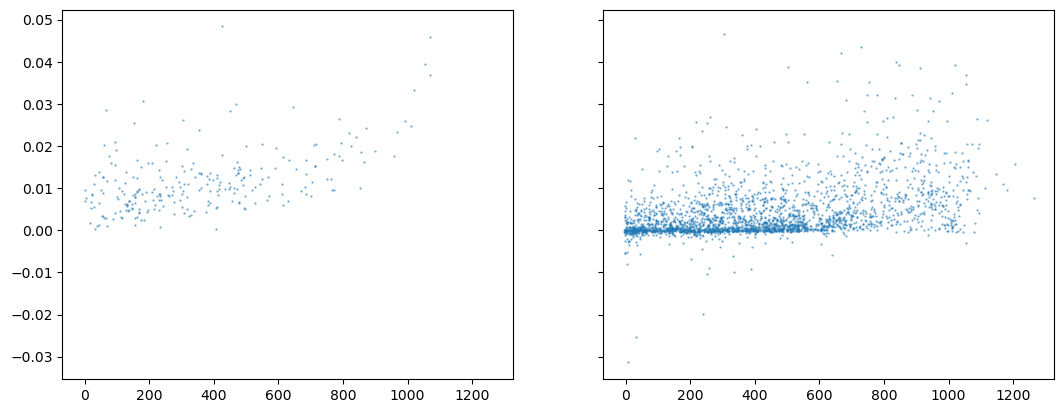

In [127]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
axes[0].scatter(|
    blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value,
    blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value,
    calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)a


In [ ]:
calm_data.variable.unique()

In [ ]:
src = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_tgrad = src[src['time'].isin(calm_data.query("variable == 'temp_gradient_2m_c'").query("value > 0").time)]
src_neg_tgrad = src[src['time'].isin(calm_data.query("variable == 'temp_gradient_2m_c'").query("value <= 0").time)]


fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
axes[0].scatter(
    src_neg_tgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_tgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    src_pos_tgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_tgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)

In [ ]:
q_grad_df = calm_data[calm_data.variable.isin(['Tsurfmixingratio_rad_c', 'mixingratio_2m_c'])][['variable', 'value', 'time']].(index=['time'], values='value', columns='variable').reset_index()pivot_table
q_grad_df['q_grad'] = q_grad_df['mixingratio_2m_c'] - q_grad_df['Tsurfmixingratio_rad_c']
positive_q_grad_timestamps = q_grad_df.query("q_grad > 0").time
negative_q_grad_timestamps = q_grad_df.query("q_grad <= 0").time

src = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_qgrad = src[src['time'].isin(positive_q_grad_timestamps)]
src_neg_qgrad = src[src['time'].isin(negative_q_grad_timestamps)]


fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True)
axes[0,0].scatter(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,0].set_xlim(0,1200)
axes[0,1].scatter(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,1].set_xlim(0,1200)
axes[1,0].scatter(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,0].set_xlim(0,10)
axes[1,1].scatter(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,1].set_xlim(0,10)

In [ ]:
print(spearmanr(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value.values,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

print(spearmanr(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value.values,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

print(spearmanr(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value.values,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

print(spearmanr(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value.values,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

In [ ]:
q_grad_df = blowing_snow_data[blowing_snow_data.variable.isin(['Tsurfmixingratio_rad_c', 'mixingratio_2m_c'])][['variable', 'value', 'time']].pivot_table(index=['time'], values='value', columns='variable').reset_index()
q_grad_df['q_grad'] = q_grad_df['mixingratio_2m_c'] - q_grad_df['Tsurfmixingratio_rad_c']
positive_q_grad_timestamps = q_grad_df.query("q_grad > 0").time
negative_q_grad_timestamps = q_grad_df.query("q_grad <= 0").time

src = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_qgrad = src[src['time'].isin(positive_q_grad_timestamps)]
src_neg_qgrad = src[src['time'].isin(negative_q_grad_timestamps)]


fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True)
axes[0,0].scatter(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,0].set_xlim(0,1200)
axes[0,1].scatter(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,1].set_xlim(0,1200)
axes[1,0].scatter(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,0].set_xlim(0,10)
axes[1,1].scatter(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,1].set_xlim(0,10)

In [ ]:
print(spearmanr(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value.values,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

print(spearmanr(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value.values,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

print(spearmanr(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value.values,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

print(spearmanr(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value.values,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value.values,
    nan_policy='omit'
))

## Daily data

In [ ]:
combo_df["synoptically active"] = combo_df["wspd"] > 5
combo_df["clear sky"] = combo_df['percent_opaque'] < 35

In [ ]:
combo_df['season'] = ''
combo_df.loc[combo_df['time'] <= '2023-02-28', 'season'] = 'winter'
combo_df.loc[combo_df['time'] > '2023-02-28', 'season'] = 'spring'

In [ ]:
combo_df['Daily sublimation (mm)'] = combo_df['Cumulative sublimation (mm)'].diff().fillna(0)

In [ ]:
def r2_string(x, y):
    regress = linregress(x,y)
    return f"r2: {round(regress.rvalue, 2)}, p: {round(regress.pvalue, 3)}"

In [ ]:
print("Spring season, SW radiation as predictor: " + r2_string(
    combo_df.query("season == 'spring'")["shortwave radiation incoming"],
    combo_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    combo_df.query("season == 'winter'")["shortwave radiation incoming"],
    combo_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    combo_df.query("season == 'spring'")["snow flux"],
    combo_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    combo_df.query("season == 'winter'")["snow flux"],
    combo_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, with clear sky: " + r2_string(
    combo_df[combo_df['clear sky']].query("season == 'spring'")["shortwave radiation incoming"],
    combo_df[combo_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, with clear sky: " + r2_string(
    combo_df[combo_df['clear sky']].query("season == 'winter'")["shortwave radiation incoming"],
    combo_df[combo_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, with clear sky: " + r2_string(
    combo_df[combo_df['clear sky']].query("season == 'spring'")["snow flux"],
    combo_df[combo_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, with clear sky: " + r2_string(
    combo_df[combo_df['clear sky']].query("season == 'winter'")["snow flux"],
    combo_df[combo_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, without clear sky: " + r2_string(
    combo_df[~combo_df['clear sky']].query("season == 'spring'")["shortwave radiation incoming"],
    combo_df[~combo_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, without clear sky: " + r2_string(
    combo_df[~combo_df['clear sky']].query("season == 'winter'")["shortwave radiation incoming"],
    combo_df[~combo_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, without clear sky: " + r2_string(
    combo_df[~combo_df['clear sky']].query("season == 'spring'")["snow flux"],
    combo_df[~combo_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, without clear sky: " + r2_string(
    combo_df[~combo_df['clear sky']].query("season == 'winter'")["snow flux"],
    combo_df[~combo_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(combo_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    combo_df
    # combo_df[combo_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring with clear/Not-clear sky')

In [ ]:
print("Spring season, SW radiation as predictor: " + r2_string(
    combo_df.query("season == 'spring'")["shortwave radiation incoming"],
    combo_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    combo_df.query("season == 'winter'")["shortwave radiation incoming"],
    combo_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    combo_df.query("season == 'spring'")["snow flux"],
    combo_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    combo_df.query("season == 'winter'")["snow flux"],
    combo_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, synoptically active: " + r2_string(
    combo_df[combo_df['synoptically active']].query("season == 'spring'")["shortwave radiation incoming"],
    combo_df[combo_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, synoptically active: " + r2_string(
    combo_df[combo_df['synoptically active']].query("season == 'winter'")["shortwave radiation incoming"],
    combo_df[combo_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, synoptically active: " + r2_string(
    combo_df[combo_df['synoptically active']].query("season == 'spring'")["snow flux"],
    combo_df[combo_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, synoptically active: " + r2_string(
    combo_df[combo_df['synoptically active']].query("season == 'winter'")["snow flux"],
    combo_df[combo_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, not synoptically active: " + r2_string(
    combo_df[~combo_df['synoptically active']].query("season == 'spring'")["shortwave radiation incoming"],
    combo_df[~combo_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, not synoptically active: " + r2_string(
    combo_df[~combo_df['synoptically active']].query("season == 'winter'")["shortwave radiation incoming"],
    combo_df[~combo_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, not synoptically active: " + r2_string(
    combo_df[~combo_df['synoptically active']].query("season == 'spring'")["snow flux"],
    combo_df[~combo_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, not synoptically active: " + r2_string(
    combo_df[~combo_df['synoptically active']].query("season == 'winter'")["snow flux"],
    combo_df[~combo_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(combo_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("synoptically active"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    combo_df
    # combo_df[combo_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("synoptically active"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring with synoptically active/not')

In [ ]:
src = combo_df[combo_df['clear sky'] & ~combo_df["synoptically active"]]

print("Spring season, SW radiation as predictor: " + r2_string(
    src.query("season == 'spring'")["shortwave radiation incoming"],
    src.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    src.query("season == 'winter'")["shortwave radiation incoming"],
    src.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    src.query("season == 'spring'")["snow flux"],
    src.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    src.query("season == 'winter'")["snow flux"],
    src.query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(src).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    src
    # combo_df[combo_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring during clear sky, synoptically weak days')

## High rate data

In [ ]:
(
    alt.Chart(tidy_df_30Min).transform_filter(
        alt.FieldOneOfPredicate('variable', ['w_h2o__3m_c'])
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("variable:N")
    )  
+ 
    alt.Chart(tidy_df_30Min).transform_filter(
        alt.FieldOneOfPredicate('variable', ['Rsw_in_9m_d'])
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("variable:N")
    ) 
).resolve_scale(y='independent').properties(width=1000).interactive()

In [ ]:
wide_df = tidy_df_30Min[
    tidy_df_30Min["variable"].isin(['w_h2o__3m_c', 'Rsw_in_9m_d', 'SF_avg_1m_ue', 'SF_avg_2m_ue'])
][['time', 'variable', 'value']].pivot_table(values = 'value', index='time', columns=['variable']).reset_index()

wide_df['SF_avg_ue'] =  wide_df[['SF_avg_1m_ue',	'SF_avg_2m_ue']].mean(axis=1)

wide_df

In [ ]:
clear_sky_syn_weak_days = combo_df[combo_df['clear sky'] & ~combo_df["synoptically active"]]['time'].dt.date

In [ ]:
wide_df_clear_sky_syn_weak = wide_df[wide_df['time'].dt.date.isin(clear_sky_syn_weak_days)]
wide_df_clear_sky_syn_weak = wide_df_clear_sky_syn_weak[wide_df_clear_sky_syn_weak["Rsw_in_9m_d"] > 0]

In [ ]:
alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("Rsw_in_9m_d:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("SF_avg_ue:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(wide_df_clear_sky_syn_weak).transform_filter(
    alt.datum.SF_avg_ue > 0
).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("SF_avg_ue:Q").scale(type='log'),
    alt.Y("w_h2o__3m_c:Q")
)